# Computer Vision & Deep Learning

## Project: Build an Vehicle Detection & Tracking Pipeline

The goals of this project are to:
    1. Perform camera calibration using a set of chessboard images
    2. Correct for distortion in raw images using the camera callibration matrix and distortion coefficients
    3. Train a real-time tiny_YOLO-v2 classifier on these images/video pipeline to obtain bounding boxes.

## Step 0: Import required packages

In [7]:
## LIST OF ALL IMPORTS

import math
import time
import os
import os.path as path
import pickle
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob

import keras
print(keras.__version__)
from yolo_utils import load_weights, draw_box, yolo_net_out_to_car_boxes, BoundingBox
# from neural_networks_yolo import build_tinyyolo
from keras.layers.core import Dense, Flatten
from keras.layers.pooling import MaxPooling2D
from keras.layers import Convolution2D
from keras.models import Sequential, load_model
from keras.layers.advanced_activations import LeakyReLU

from datetime import datetime
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

keras.backend.set_image_dim_ordering('th')

2.0.5


## Step 1: Camera Calibration (from Advanced Lane-finding pipeline)

Extracting 3D object, and 2D image arrays from sample chessboard images.
Camera Calibration initialized.
Detected corners for image 0.
Detected corners for image 1.
Detected corners for image 3.
Detected corners for image 4.
Detected corners for image 6.
Detected corners for image 7.
Detected corners for image 8.
Detected corners for image 9.
Detected corners for image 10.
Detected corners for image 11.
Detected corners for image 12.
Detected corners for image 14.
Detected corners for image 15.
Detected corners for image 16.
Detected corners for image 17.
Detected corners for image 18.
Detected corners for image 19.
(9,6) pattern corners cannot be detected in 3 images in the camera_cal folder.


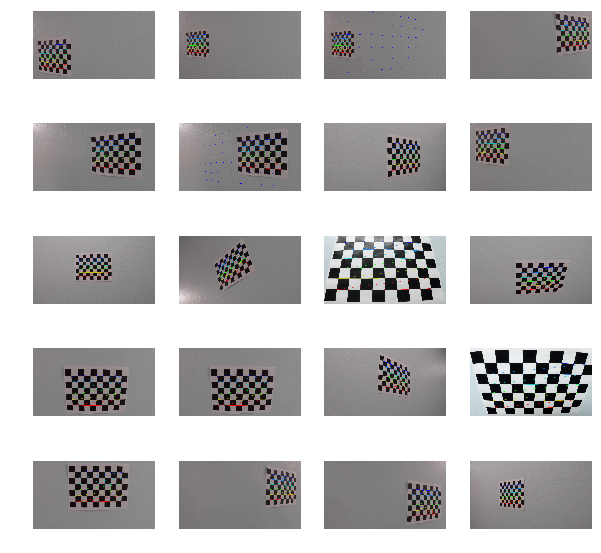

In [8]:
from camera_image_calibration import calibrate_camera

print("Extracting 3D object, and 2D image arrays from sample chessboard images.")
path='camera_cal/calibration*.jpg'
obj_array,img_array,cal_images,uncal_images=calibrate_camera(path)

Using image and object arrays to calibrate & undistort camera images.
Pickle exists, ignoring pickle creation step.


Text(0.5,1,'Undistorted Image')

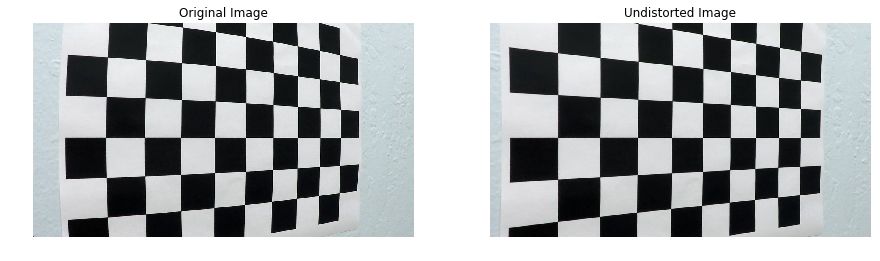

In [9]:
from camera_image_calibration import undistortion

print("Using image and object arrays to calibrate & undistort camera images.")

test_imagepath='camera_cal/calibration5.jpg'
src_image=cv2.imread(test_imagepath)

undistorted_image, camera_matrix, distortion_coefficients=undistortion(src_image,obj_array,img_array)

pickle_path="undistortion_pickle.p"

if (os.path.isfile(pickle_path)):
    print("Pickle exists, ignoring pickle creation step.")
else:
    try:
        print("Pickling camera matrix and distortion coefficients.")
        pickled=open(pickle_path,'wb')
        save={
            'dist_matrix': camera_matrix,
            'dist_coefficients': distortion_coefficients
        }
        pickle.dump(save,pickled)
        pickled.close()
        print("Data pickled.")
    except:
        print("Error in pickling. Debug.")

fig,(ax_orig,ax_undist)=plt.subplots(1,2,figsize=(15,10))
ax_orig.imshow(src_image)
ax_orig.axis('off')
ax_orig.set_title('Original Image')

ax_undist.imshow(undistorted_image)
ax_undist.axis('off')
ax_undist.set_title('Undistorted Image')

## Step 2: Distortion Correction (from Advanced Lane-finding pipeline)

In [10]:
from camera_image_calibration import undistort

# Load saved pickled data for matrix and distortion coefficients
pickle_path='undistortion_pickle.p'

with open(pickle_path,mode='rb') as f:
        undistort_data=pickle.load(f)
undistort_camera_matrix,undistort_coefficients=undistort_data['dist_matrix'], undistort_data['dist_coefficients']

print("Loading image undistortion coefficients, matrix from {}.".format(pickle_path))

Loading image undistortion coefficients, matrix from undistortion_pickle.p.


Testing out undistortion algorithm on sample chessboard images.


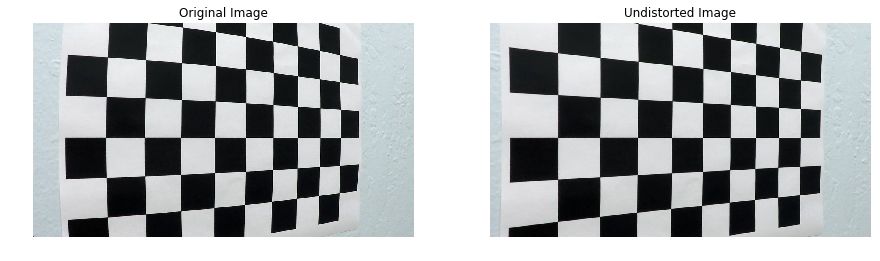

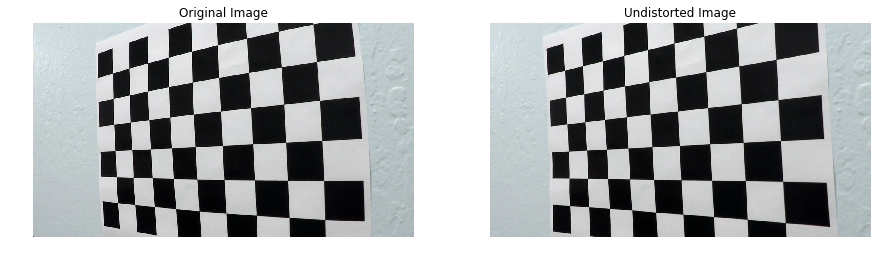

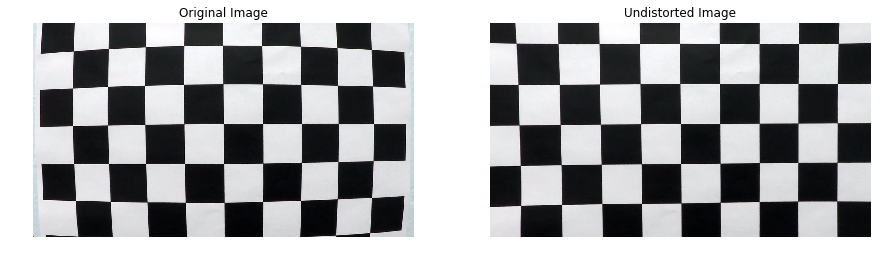

In [11]:
# Test out undistortion on chessboard images which weren't able to be used for finding corners
print("Testing out undistortion algorithm on sample chessboard images.")
num_plots=3
count=0

for image in uncal_images:
    fig,(ax_orig,ax_undist)=plt.subplots(1,2,figsize=(15,10))

    ax_orig.imshow(image)
    ax_orig.set_title('Original Image')
    ax_orig.axis('off')
    
    ax_undist.imshow(undistort(image,undistort_camera_matrix,undistort_coefficients))
    ax_undist.set_title('Undistorted Image')
    ax_undist.axis('off')
        
    if count>=num_plots:
        break
    count+=1

Testing out undistortion algorithm on sample driving camera image.


Text(0.5,1,'Undistorted Image')

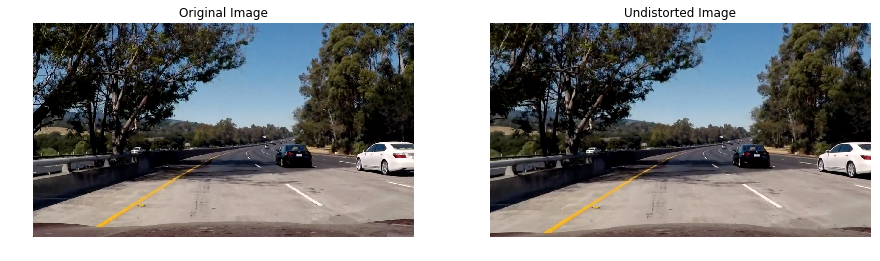

In [12]:
# Test out undistortion on a test_image 
from feature_analysis import display

print("Testing out undistortion algorithm on sample driving camera image.")

test_imagepath='test_images/test5.jpg'
test_image=display(cv2.imread(test_imagepath))
undistort_image=undistort(test_image,undistort_camera_matrix,undistort_coefficients)
fig,(ax_orig,ax_undist)=plt.subplots(1,2,figsize=(15,10))
ax_orig.imshow(test_image)
ax_orig.axis('off')
ax_orig.set_title('Original Image')

ax_undist.imshow(undistort_image)
ax_undist.axis('off')
ax_undist.set_title('Undistorted Image')

## Step 3: Dataset exploration

In [ ]:
from feature_analysis import display

print("Dataset exploration and visualization.")

vehicles_path='datasets/vehicles/*/*.png'
nonvehicles_path='datasets/non-vehicles/*/*.png'
save_raw_pickle_path='raw_dataset.p'
redo=0
if (os.path.isfile(save_raw_pickle_path) and redo==0):
    print("Pickle exists, ignoring pickle creation step.")
else:
    try:
        cars=[]
        noncars=[]

        print("Loading required data...")
        vehicle_images=glob.glob(vehicles_path)
        other_images=glob.glob(nonvehicles_path)

        for img in vehicle_images:
            cars.append(display(cv2.imread(img)))
        for img in other_images:
            noncars.append(display(cv2.imread(img)))

        cars=np.asarray(cars)
        noncars=np.asarray(noncars)
        print("Arrays created.")

        print("Pickling raw car- and non-car dataset images.")
        pickled=open(save_raw_pickle_path,'wb')
        save={
            'car': cars,
            'non_car': noncars
        }
        pickle.dump(save,pickled)
        pickled.close()
        print("Data pickled.")
    except:
        print("Error in pickling. Debug.")

In [ ]:
with open(save_raw_pickle_path,mode='rb') as f:
        car_data=pickle.load(f)
car_dataset,noncar_dataset=car_data['car'], car_data['non_car']

print("Loading raw image dataset from {}.".format(save_raw_pickle_path))
print("Dataset contains {} car images & {} non-car images.".format(len(car_dataset),len(noncar_dataset)))
print("Images are of shape: {}.\n".format(car_dataset[0].shape))

car_dataset.flags.writeable=False
noncar_dataset.flags.writeable=False
car_hash=set([hash(image.tobytes()) for image in car_dataset])
noncar_hash=set([hash(image.tobytes()) for image in noncar_dataset])
car_duplicates=len(car_dataset)-len(car_hash)
noncar_duplicates=len(noncar_dataset)-len(noncar_hash)

print("There are {} duplicate images in car_dataset, {} duplicate images in noncar_dataset.".
      format(car_duplicates,noncar_duplicates))

In [ ]:

fig, ax=plt.subplots(4,6, figsize=(15, 10))
ax=ax.ravel()
for i in np.arange(12):
    c_ind=np.random.randint(0,len(car_dataset))
    img=(car_dataset[c_ind])
    ax[i].axis('off')
    ax[i].imshow(img)
    ax[i].set_title('Vehicle {}'.format(i+1))
for i in np.arange(12,24):
    nc_ind=np.random.randint(0,len(noncar_dataset))
    img=(noncar_dataset[nc_ind])
    ax[i].axis('off')
    ax[i].imshow(img)
    ax[i].set_title('Non-vehicle {}'.format(i+1))

NOTE: When using SVM (or similar Machine learning algorithms) or even Lenet, vehicle and non-vehicle images need to be modified before being used as a dataset. Namely, previously data has been extracted, normalized (as it contains features from color histogram, spatial binning, and HOG spatial-features), and has dimensionality reduction done to it (PCA) to find latent features and remove unnecessary features.

For the case of SSD, Yolo-V2 or Tiny-Yolo no extraction of features is needed.

## Step 4: Classifier Creation

The classifier used here is the Tiny-YOLO neural-network  which assists real-time object detection (better than Fast-RCNN or SSD etc). The network is pretrained on the VOC2012 dataset. The dataset has classes of [aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, dining table, dog, horse, motorbike, person, potted plant, sheep, sofa, train, tv monitor]. The network doesn't need to be retrained, as we are interested in the car class, and can be sure that most other labels will not be seen.
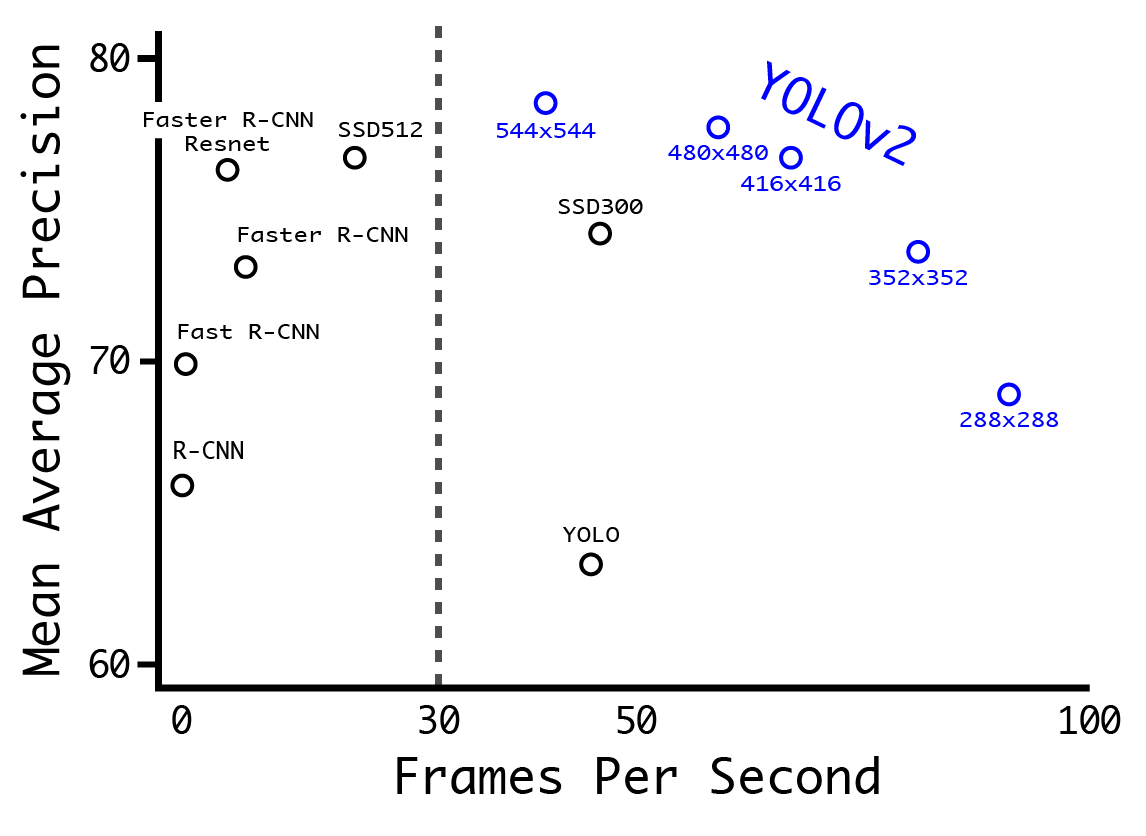<!-- .element height="50%" width="50%" -->

In [13]:
print("Using Tiny-YOLO model.")

model=Sequential()
model.add(Convolution2D(16,3,3,input_shape=(3,448,448),border_mode='same',subsample=(1,1),name='Conv1'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2),name='MaxPool1'))

model.add(Convolution2D(32,3,3,border_mode='same',name='Conv2'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2),border_mode='valid',name='MaxPool2'))

model.add(Convolution2D(64,3,3,border_mode='same',name='Conv3'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2),border_mode='valid',name='MaxPool3'))

model.add(Convolution2D(128,3,3,border_mode='same',name='Conv4'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2),border_mode='valid',name='MaxPool4')) 

model.add(Convolution2D(256,3,3,border_mode='same',name='Conv5'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2),border_mode='valid',name='MaxPool5'))

model.add(Convolution2D(512,3,3,border_mode='same',name='Conv6'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2),border_mode='valid',name='MaxPool6'))                       

model.add(Convolution2D(1024,3,3,border_mode='same',name='Conv7'))
model.add(LeakyReLU(alpha=0.1))
    
model.add(Convolution2D(1024,3,3,border_mode='same',name='Conv8'))
model.add(LeakyReLU(alpha=0.1))
    
model.add(Convolution2D(1024,3,3,border_mode='same',name='Conv9'))
model.add(LeakyReLU(alpha=0.1))

model.add(Flatten())
model.add(Dense(256))
model.add(Dense(4096))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1470))

Using Tiny-YOLO model.


In [14]:
model.summary()
print("Loading pretrained weights.")
weights_path='yolo_weights/yolo-tiny.weights'
load_weights(model,weights_path)
print("Weights loaded.")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 16, 448, 448)      448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 448, 448)      0         
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 16, 224, 224)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 224, 224)      4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 224, 224)      0         
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 32, 112, 112)      0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 64, 112, 112)      18496     
__________

The output of the DNN is a 1470 row vector that has information regarding probability [980], confidence [98], and bounding box coordinates [392] of predicted boxes.

## Step 5: Pipeline Implementation

### Image Pipeline- Test Images

In [15]:
def pipeline(raw_image):
    undistort_image=undistort(raw_image,undistort_camera_matrix,undistort_coefficients)
    undistort_image=raw_image[300:650,500:,:]
    resized_image=cv2.resize(undistort_image,(448,448))
        
    normalized_image=np.transpose(resized_image,(2,0,1))
    image_processed=np.expand_dims(((normalized_image/127.5)-1),axis=0)
    prediction=model.predict(image_processed)
    bboxes=yolo_net_out_to_car_boxes(prediction[0],threshold=0.20)
    print(bboxes)
    return bboxes

In [16]:
def video_pipeline(image_frame):
    undistort_image=undistort(image_frame,undistort_camera_matrix,undistort_coefficients)
    undistort_image=undistort_image[300:650,500:,:]
    resized_image=cv2.resize(undistort_image,(448,448))
    reshaped=np.array([resized_image[:,:,0],resized_image[:,:,1],resized_image[:,:,2]])
    
    image_processed=np.expand_dims(((reshaped/127.5)-1),axis=0)
    prediction=model.predict(image_processed)
    bboxes=yolo_net_out_to_car_boxes(prediction[0],threshold=0.2)
    return draw_box(bboxes,image_frame,[[500,1280],[300,650]])

In [17]:
images_source='test_images/'
images_save='yolo_images_output/'

image_name_list=os.listdir(images_source)

print("Utilizing lane-finding pipeline on image feed.")

Utilizing lane-finding pipeline on image feed.


Using image test2.jpg from test_images/...
[]


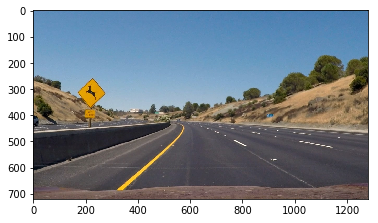

Saving image test2.jpg in yolo_images_output/...
Using image test6.jpg from test_images/...
[<yolo_utils.BoundingBox object at 0x7f2280b26828>, <yolo_utils.BoundingBox object at 0x7f22806a5cc0>]


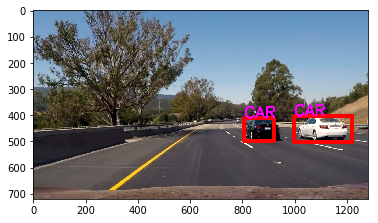

Saving image test6.jpg in yolo_images_output/...
Using image test3.jpg from test_images/...


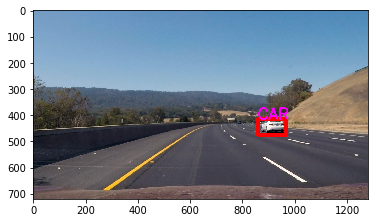

Saving image test3.jpg in yolo_images_output/...
Using image test4.jpg from test_images/...
[<yolo_utils.BoundingBox object at 0x7f22806ef6a0>, <yolo_utils.BoundingBox object at 0x7f22804d8080>]


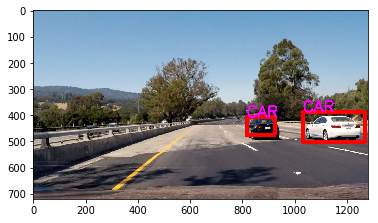

Saving image test4.jpg in yolo_images_output/...
Using image test7.jpg from test_images/...
[<yolo_utils.BoundingBox object at 0x7f2280420cc0>, <yolo_utils.BoundingBox object at 0x7f22806d7c88>, <yolo_utils.BoundingBox object at 0x7f2280420b38>, <yolo_utils.BoundingBox object at 0x7f227bfe2550>]


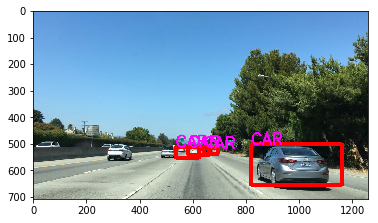

Saving image test7.jpg in yolo_images_output/...
Using image test1.jpg from test_images/...
[<yolo_utils.BoundingBox object at 0x7f2280715f28>, <yolo_utils.BoundingBox object at 0x7f22806896a0>]


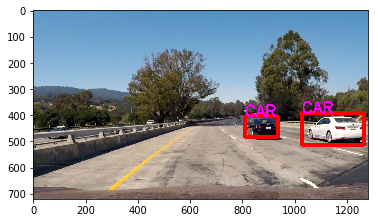

Saving image test1.jpg in yolo_images_output/...
Using image test5.jpg from test_images/...
[<yolo_utils.BoundingBox object at 0x7f2280a08c88>, <yolo_utils.BoundingBox object at 0x7f227bfc7128>]


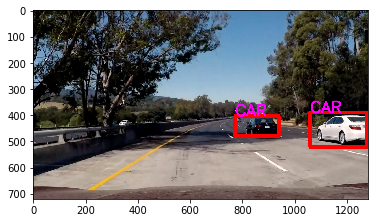

Saving image test5.jpg in yolo_images_output/...


In [18]:
for image_local in image_name_list:
    print("Using image {} from {}...".format(image_local,images_source))
    read_image=plt.imread(os.path.join(images_source,image_local))
    boxes=pipeline(read_image)
    
    processed_image=draw_box(boxes,read_image,[[500,1280],[300,650]])
    plt.imshow(processed_image)
    plt.show()
    
    print("Saving image {} in {}...".format(image_local,images_save))
    saved_image=cv2.imwrite(os.path.join(images_save,image_local),cv2.cvtColor(processed_image,cv2.COLOR_RGB2BGR))

### Video Pipeline- Test Video

In [19]:
test_output = 'yolo_videos_output/test_video.mp4'
clip1 = VideoFileClip("test_videos/test_video.mp4")
test_clip = clip1.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video yolo_videos_output/test_video.mp4
[MoviePy] Writing video yolo_videos_output/test_video.mp4


 97%|█████████▋| 38/39 [00:48<00:01,  1.31s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yolo_videos_output/test_video.mp4 

CPU times: user 1min 31s, sys: 992 ms, total: 1min 32s
Wall time: 51.9 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

### Video Pipeline- Main Video

In [21]:
main_output = 'yolo_videos_output/project_video.mp4'
clip2 = VideoFileClip("test_videos/project_video.mp4")
main_clip = clip2.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time main_clip.write_videofile(main_output, audio=False)

[MoviePy] >>>> Building video yolo_videos_output/project_video.mp4
[MoviePy] Writing video yolo_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [27:29<00:01,  1.27s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yolo_videos_output/project_video.mp4 

CPU times: user 50min 58s, sys: 32.7 s, total: 51min 31s
Wall time: 27min 37s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(main_output))

### Video Pipeline- Supplementary Videos: Night Driving

In [27]:
alternative_sample_night_drive_output = 'yolo_videos_output/alternative_sample_night_drive.mp4'
clip5 = VideoFileClip("test_videos/alternative_sample_night_drive.mp4")
alternative_sample_night_drive_clip = clip5.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time alternative_sample_night_drive_clip.write_videofile(alternative_sample_night_drive_output, audio=False)

[MoviePy] >>>> Building video yolo_videos_output/alternative_sample_night_drive.mp4
[MoviePy] Writing video yolo_videos_output/alternative_sample_night_drive.mp4


100%|█████████▉| 761/762 [13:41<00:01,  1.33s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yolo_videos_output/alternative_sample_night_drive.mp4 

CPU times: user 30min 21s, sys: 19.2 s, total: 30min 40s
Wall time: 13min 45s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(alternative_sample_night_drive_output))

In [ ]:
print("Script terminated at",str(datetime.now()))